In [ ]:
# Configures the Environment (run it once)
include("configure.jl")

# Configuration of the Quadrotor

In [36]:
include("Model_nd_Dynamics.jl")
include("Simulation.jl")
include("Trajectory.jl")
include("MPC.jl")
include("Close_loop.jl")
include("LQR.jl")

  Activating project at `/notebooks/notebooks`
  Activating project at `/notebooks/notebooks`
  Activating project at `/notebooks/notebooks`
  Activating project at `/notebooks/notebooks`
  Activating project at `/notebooks/notebooks`
  Activating project at `/notebooks/notebooks`


lqr_controller

In [38]:
model = Model(0.0, 0.0, 0.0, I(3), 0.0, 0.0, 0.0, zeros(4), zeros(4),0.0,0.0, 0, 0)
model.g = 9.81 # [m/s^2]
model.m = 0.5 # [kg]
model.ℓ = 0.1750 # [meters]
model.J = Diagonal([0.0023, 0.0023, 0.004]) # [kg . m^2]
model.R = 0.04 # [meters]
model.prop_min_h = 0.1 # [meters]
model.ρ = 1.0 # dimensionless
model.kt = 1.0
model.km = 0.0245
model.Nx = 13
model.Nu = 4

#Thrust limits
model.umin = 0.0 * model.m * model.g * ones(4)
model.umax = 2.0 * model.m * model.g * ones(4)

## Simulation Configs
#
# Universe 1000Hz
# Controller 100Hz

h_universe = 0.0001 # Time step (10 kHz)
h_controller = 0.004 # Time step (200 Hz)
Tfinal = 10.0 # Simulate from 0 - 10 seconds

simulation = Simulation(h_universe, h_controller, Tfinal)

landing_start_height = 3.0
stationary_height = model.prop_min_h + 0.06 # 6 centimeters above the ground
plat_amplitude = 0.1
plat_freq = 0.3

traj_params = Trajectory(plat_amplitude, plat_freq, landing_start_height, stationary_height)

state_space = LinearStateSpace(model, simulation, (model.Nx - 1), model.Nu, stationary_height)

Nh = 20
Nc = 42 # For now is unused...

# Cost weights
#Q = Array(10.0*I(Nx));
#Q[3,3] = 1000.0
#R = Array(.01*I(Nu));
#Qn = Array(1000.0*I(Nx));
Qn = Array(I(model.Nx - 1));
Q = Array(I(model.Nx - 1));
R = Array(.1*I(model.Nu));

tunning_params = MPCTunningParameters(Nh, Nc, Q, R, Qn)

mpc_mats =  MPCMatrices(model, state_space, tunning_params)

# Initial State!
theta = 10 * pi / 180  # 10 graus em rad
q0 = [cos(theta/2), sin(theta/2), 0.0, 0.0]
x0 = [1.0; 2.0; traj_params.init_heigth; q0 ; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0]

#xhist1, uhist1 = closed_loop(x0, (t,x)->lqr_controller(t,x,K,x_ref), Nt);
#xhist2, uhist2 = closed_loop(x0, (t,x)->mpc_controller(t,x,x_ref), Nt);
#xhist3, uhist3, plathist3, refyhist3, drefyhist3, land_time, land_mark = closed_loop(
out = closed_loop(
    x0,
    state_space,
    tunning_params, 
    traj_params,
    simulation,
    model,

    (t, x) -> mpc_controller(
        model,
        simulation,
        tunning_params,
        traj_params,
        state_space,
        mpc_mats,
        t,
        x, 
        gen_ref(model, traj_params, tunning_params, t, simulation.h_controller) # verify if this works as expected!!
    )
);

In [39]:
out_lqr = closed_loop(
    x0,
    state_space,
    tunning_params, 
    traj_params,
    simulation,
    model,

    (t, x) -> lqr_controller(
        model,
        simulation,
        tunning_params,
        traj_params,
        state_space,
        t,
        x, 
        gen_ref(model, traj_params, tunning_params, t, simulation.h_controller) # verify if this works as expected!!
    )
);

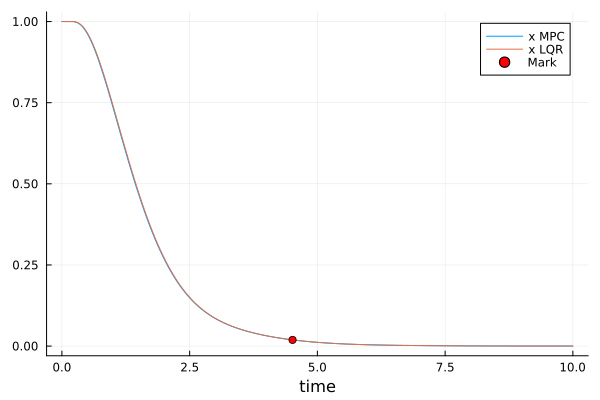

In [40]:
using Plots

thist = Array(range(0, simulation.h_universe * (simulation.Nt_universe - 1), step = simulation.h_universe));

# Define máximo de pontos que queremos exibir
max_points = 1000

# Calcula índice de salto (skip)
stride = max(1, floor(Int, length(thist) / max_points))

# Aplica o salto nos pontos
thist_sampled = thist[1:stride:end]
x_sampled = out.x_quad[1,1:stride:end]
x_lqr = out_lqr.x_quad[1,1:stride:end]

# Plota linha reduzida
plot(thist_sampled, x_sampled, label="x MPC")
plot!(thist_sampled, x_lqr, label="x LQR")

# Mantém o scatter do ponto especial
scatter!([out.land_time], [out.x_quad[1, out.land_mark]], label="Mark", color=:red, markersize=4)

xlabel!("time")

#savefig("Test01.svg")

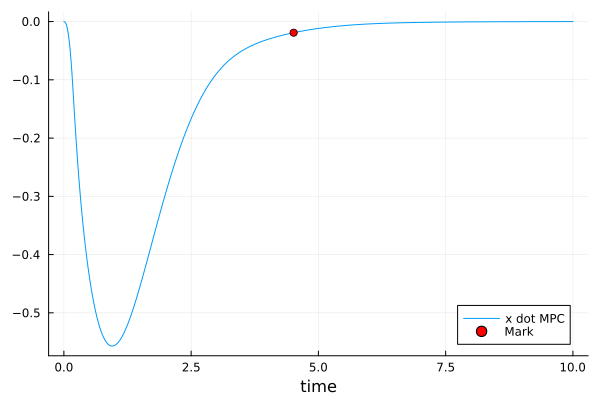

In [41]:
# Aplica o salto nos pontos
x_dot_sampled = out.x_quad[8,1:stride:end]

plot(thist_sampled, x_dot_sampled, label="x dot MPC")
scatter!([out.land_time], [out.x_quad[8, out.land_mark]], label="Mark", color=:red, markersize=4)

xlabel!("time")

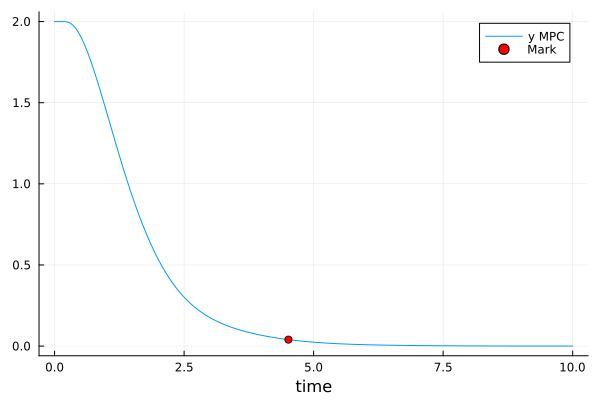

In [42]:
# Aplica o salto nos pontos
y_sampled = out.x_quad[2,1:stride:end]

plot(thist_sampled, y_sampled, label="y MPC")
scatter!([out.land_time], [out.x_quad[2, out.land_mark]], label="Mark", color=:red, markersize=4)

xlabel!("time")

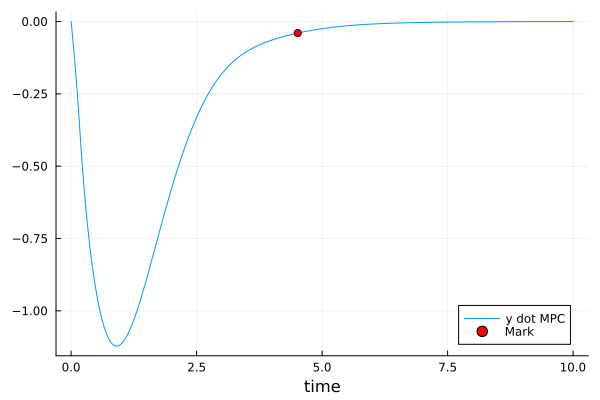

In [43]:
# Aplica o salto nos pontos
y_dot_sampled = out.x_quad[9,1:stride:end]

plot(thist_sampled, y_dot_sampled, label="y dot MPC")
scatter!([out.land_time], [out.x_quad[9, out.land_mark]], label="Mark", color=:red, markersize=4)

xlabel!("time")

In [44]:
# Aplica o salto nos pontos
#θ_sampled = out.x_quad[3,1:stride:end]

#plot(thist_sampled, θ_sampled, label="θ MPC")

#scatter!([land_time], [out.x_quad[3,land_mark]], label="Mark", color=:red, markersize=4)
#xlabel!("time")

In [45]:
# Aplica o salto nos pontos
#θ_dot_sampled = out.x_quad[6,1:stride:end]

#plot(thist, out.x_quad[6, :], label="θ dot MPC")
#scatter!([land_time], [out.x_quad[6,land_mark]], label="Mark", color=:red, markersize=4)

#xlabel!("time")

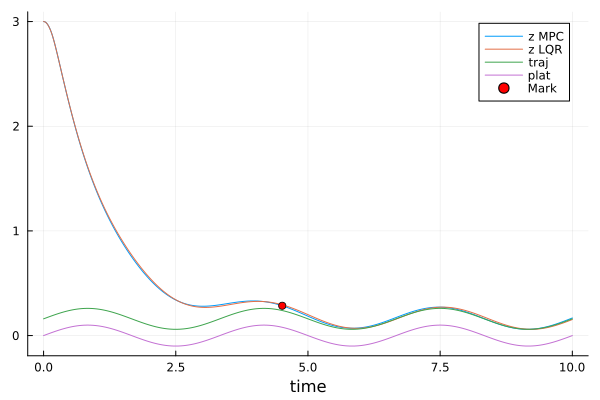

In [46]:
# Aplica o salto nos pontos
z_quad_sampled = out.x_quad[3,1:stride:end]
z_plat_sampled = out.x_plat[3,1:stride:end]
z_ref_sampled = out.x_ref[3,1:stride:end]
z_lqr = out_lqr.x_quad[3,1:stride:end]

## Plot de interesse
plot(thist_sampled, z_quad_sampled, label="z MPC")

plot!(thist_sampled, z_lqr, label="z LQR")
plot!(thist_sampled, z_ref_sampled, label="traj")
plot!(thist_sampled, z_plat_sampled, label="plat")

xlabel!("time")
scatter!([out.land_time], [out.x_quad[3, out.land_mark]], label="Mark", color=:red, markersize=4)

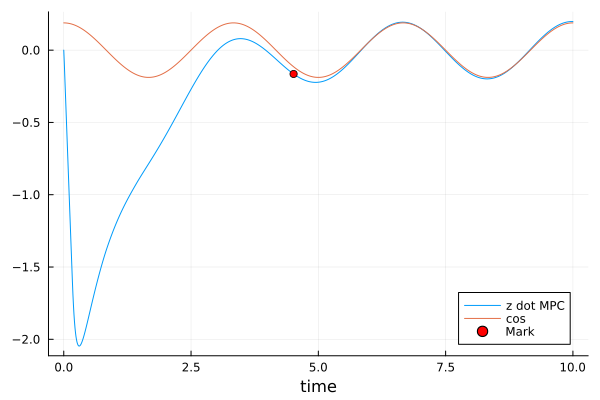

In [47]:
# Aplica o salto nos pontos
z_dot_sampled = out.x_quad[10,1:stride:end]
drefz_sampled = out.x_ref[10,1:stride:end]

plot(thist_sampled, z_dot_sampled, label="z dot MPC")
plot!(thist_sampled, drefz_sampled, label="cos")

xlabel!("time")
scatter!([out.land_time], [out.x_quad[10, out.land_mark]], label="Mark", color=:red, markersize=4)

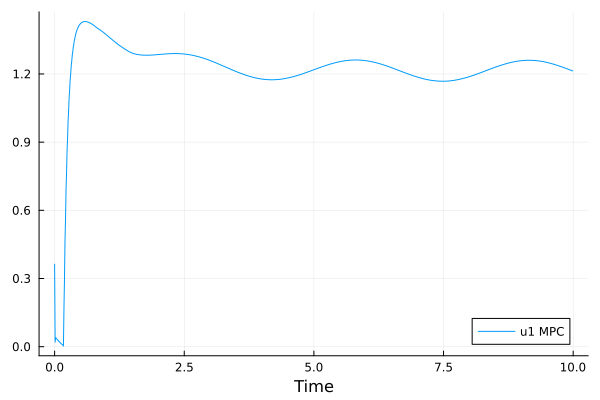

In [48]:
# Aplica o salto nos pontos
u1_sampled = out.u_quad[1,1:stride:end]

plot(thist_sampled[1:end-1], u1_sampled, label="u1 MPC")
xlabel!("Time")

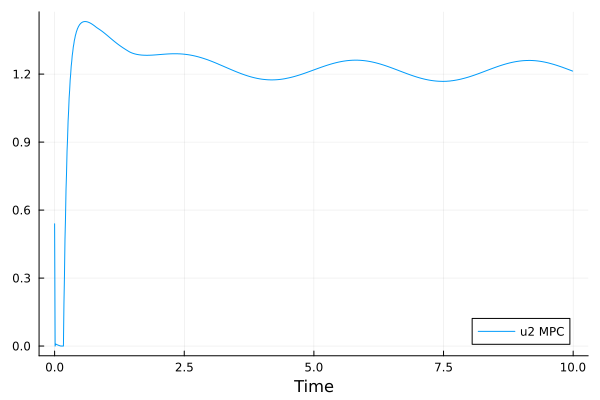

In [49]:
# Aplica o salto nos pontos
u2_sampled = out.u_quad[2,1:stride:end]

plot(thist_sampled[1:end-1], u2_sampled, label="u2 MPC")
xlabel!("Time")

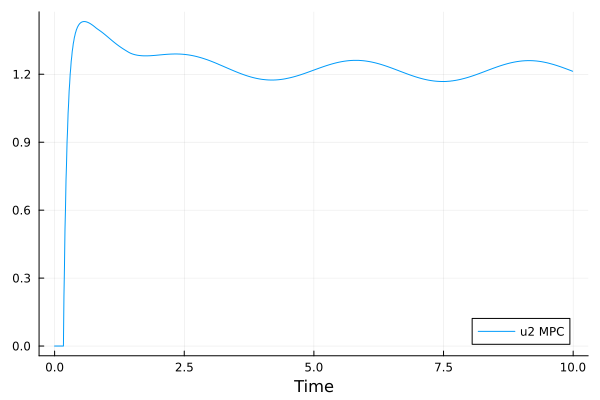

In [50]:
# Aplica o salto nos pontos
u3_sampled = out.u_quad[3,1:stride:end]

plot(thist_sampled[1:end-1], u3_sampled, label="u2 MPC")
xlabel!("Time")

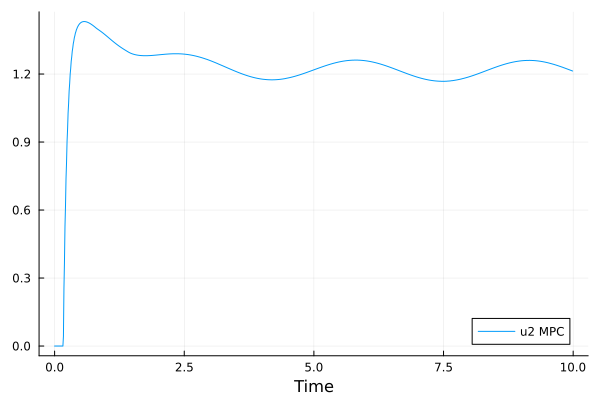

In [51]:
# Aplica o salto nos pontos
u4_sampled = out.u_quad[4,1:stride:end]

plot(thist_sampled[1:end-1], u4_sampled, label="u2 MPC")
xlabel!("Time")

In [ ]:
#Set up visualization
using TrajOptPlots
using MeshCat
using StaticArrays
using RobotZoo:Quadrotor

vis = Visualizer()
render(vis)

In [ ]:
model = Quadrotor()
TrajOptPlots.set_mesh!(vis, model)

In [ ]:
X1 = [SVector{13}(x) for x in eachcol(out.x_quad[:,1:10:end])];

visualize!(vis, model, thist[end], X1)